In [179]:
import pandas as pd
import spacy
import textacy
import os
import logging
HOME = os.getcwd()
df = pd.read_csv(os.path.join(HOME, 'stem_cell_2018_20210703.csv'), usecols = ['parsed'])
#preproc = textacy.preprocessing.make_pipeline(textacy.preprocessing.normalize.unicode,textacy.preprocessing.normalize.quotation_marks,textacy.preprocessing.normalize.whitespace)
#preproc_records = ((preproc(text), meta) for text, meta in records)
parsed_paragraphs= df.parsed.to_list()
for parsed_paragraph in parsed_paragraphs:
    parsed_paragraph.encode().decode("utf-8")
corpus = textacy.Corpus("en_core_web_sm", data=parsed_paragraphs)
#print(parsed_paragraphs)

In [ ]:
import textacy.extract
list(textacy.extract.entities(corpus[0]))

In [ ]:
from functools import partial
terms = list(textacy.extract.terms(
     corpus[0],
     ngs=partial(textacy.extract.ngrams, n=2, include_pos={"NOUN", "ADJ"}),
     ents=partial(textacy.extract.entities, include_types={"PERSON", "ORG", "GPE", "LOC"}),
     dedupe=False))
terms

In [ ]:
list(textacy.extract.terms_to_strings(terms, by="lemma"))


In [192]:
docs_terms = (
     textacy.extract.terms(
         doc,
         ngs=partial(textacy.extract.ngrams, n=2, include_pos={"NOUN", "ADJ"}),
         ents=partial(textacy.extract.entities, include_types={"PERSON", "ORG", "GPE", "LOC"}))
     for doc in corpus)
tokenized_docs = (
     textacy.extract.terms_to_strings(doc_terms, by="lemma")
     for doc_terms in docs_terms)

In [193]:
import textacy.representations
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs, tf_type="linear", idf_type="smooth")
doc_term_matrix

<77x782 sparse matrix of type '<class 'numpy.float64'>'
	with 962 stored elements in Compressed Sparse Row format>

In [194]:
import textacy.tm
model = textacy.tm.TopicModel("nmf", n_topics=3)
model.fit(doc_term_matrix)

c:\users\shweata\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [195]:
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

(77, 3)

In [196]:
doc_topic_matrix

array([[0.00000000e+00, 1.66501120e-03, 0.00000000e+00],
       [0.00000000e+00, 3.32318682e-02, 0.00000000e+00],
       [0.00000000e+00, 1.75619660e-02, 3.85506236e-04],
       [0.00000000e+00, 1.09333497e-04, 0.00000000e+00],
       [0.00000000e+00, 2.25696294e-01, 1.46770762e-02],
       [0.00000000e+00, 1.79239681e-02, 3.84669294e-04],
       [0.00000000e+00, 3.79986630e-02, 3.63137542e-04],
       [1.32145669e-02, 5.48296420e-02, 5.29871277e-03],
       [0.00000000e+00, 1.96224997e-02, 3.80742324e-04],
       [1.32576777e-02, 3.88796825e-02, 1.12834661e-01],
       [0.00000000e+00, 0.00000000e+00, 1.63150382e-01],
       [0.00000000e+00, 2.47907398e-02, 1.06896869e-02],
       [0.00000000e+00, 1.88697021e-02, 4.80204809e-03],
       [0.00000000e+00, 1.76785213e-02, 3.85236762e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.09931425e-03, 0.00000000e+00],
       [0.00000000e+00, 1.09333497e-04, 0.00000000e+00],
       [0.00000000e+00, 1.04982

In [197]:
id_to_term = {id_: term for term, id_ in vocab.items()}
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=8):
     print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: research funding   Bristol Myers Squibb   Takeda   board participation   advisory board   Karyopharm   Janssen Pharmaceuticals   Amgen
topic 1: cord blood   umbilical cord   blood unit   medical record   single intravenous   ASD   month post‐infusion   autologous umbilical
topic 2: evaluable patient   primary end   end point   treatment violation   ≥   major treatment   sample size   MTD


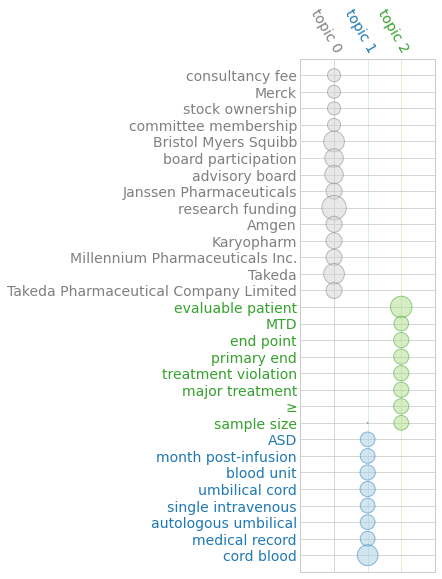

In [198]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=30, highlight_topics=[1, 2, 3, 4, 5])